# TOC
- [Process annotation map](#process_annotation)
- [Convert to COCO format](#format_coco)
- [Register dataset](#register)
- [Train model](#train)
- [Evaluation](#eval)

### refs
- polygon from pixel mask: https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#create-custom-coco-dataset
- pixel mask & full example include register (BAD annotation): https://www.kaggle.com/jeanpat/minimalist-mask-to-coco-format-dataset-conversion 
- official examples (not used): https://github.com/matterport/Mask_RCNN/blob/v2.1/samples/balloon/balloon.py, https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py



In [6]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
import regex as re
from PIL import Image       
import glob
import json
import IPython

import matplotlib.pyplot as plt 
from pathlib import Path   
from detectron2.data.datasets import register_coco_instances
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)

from helpers_coco import images_annotations_info, create_sub_masks, create_sub_mask_annotation, create_category_annotation, create_image_annotation, create_annotation_format, get_coco_json_format
from helpers_coco import CocoDataset
from helpers_coco import process_img_pixel_annotation
from helpers_coco import list_imgs_in_dir, standardize_color, clean_annotation_mask, remove_noise


In [2]:
from pathlib import Path
ampis_root =  Path('../AMPIS/')
weights_path = Path(ampis_root,'models','model_final_f10217.pkl')
# print(weights_path)
# %ls weights_path

# Process annotation map<a id='process_annotation'></a>

In [3]:
# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
# output_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/'
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_raw/'
output_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_clean_mask/'

process_img_pixel_annotation(input_dir, output_dir)



20190405_2.0_kx_micro_1724_0004_ceta_mask.png
20190405_2.0_kx_micro_1731_0000_ceta_mask.png
20190405_2.0_kx_micro_1708_0004_ceta_mask.png
20190405_2.0_kx_micro_1645_0002_ceta_mask.png
20190405_2.0_kx_micro_1724_0001_ceta_mask.png
20190405_2.0_kx_micro_1729_0000_ceta_mask.png
OVERLAPPING mask in:  20190405_2.0_kx_micro_1731_0002_ceta-2.png
20190405_2.0_kx_micro_1731_0002_ceta_mask.png
OVERLAPPING mask in:  20190405_2.0_kx_micro_1727_0001_ceta-3.png
20190405_2.0_kx_micro_1727_0001_ceta_mask.png
20190405_2.0_kx_micro_1733_0002_ceta_mask.png
20190405_2.0_kx_micro_1714_0003_ceta_mask.png
20190405_2.0_kx_micro_1729_0003_ceta_mask.png
20190405_2.0_kx_micro_1728_0003_ceta_mask.png
20190405_2.0_kx_micro_1731_0003_ceta_mask.png
20190405_2.0_kx_micro_1730_0004_ceta_mask.png
20190405_2.0_kx_micro_1646_0000_ceta_mask.png
20190405_2.0_kx_micro_1645_0001_ceta_mask.png


In [5]:
### get individual image colors
from collections import Counter
colors = Counter()
img = cv2.imread(output_dir + '20190405_2.0_kx_micro_1727_0001_ceta_mask.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in np.arange(img.shape[0]):
    for j in np.arange(img.shape[1]):
        colors[tuple(img[i, j,:])] += 1
colors


Counter({(0, 0, 0): 3350576,
         (0, 255, 0): 323693,
         (0, 0, 255): 1735,
         (255, 255, 0): 51345,
         (255, 0, 0): 465667,
         (255, 255, 255): 1288})

In [ ]:
### for all images in dir, check which ones contain (0, 255, 255)
print('images with bad color (0, 255, 255)')
for f in os.listdir(output_dir):
    img = cv2.imread(output_dir + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_active = (img[:, :, 0] == 255).astype(int) + (img[:, :, 1] == 255).astype(int)*10 + (img[:, :, 2] == 255).astype(int)*100
    count = np.sum((test_active == 110).astype(int))
    if count > 0:
        print(f, count)




In [8]:
### check color of overlapping images
errors_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_clean_mask_errors/'

cnt = 0
colors = Counter()
for f in os.listdir(errors_dir):
    img = cv2.imread(errors_dir + f)
    cnt += np.sum(img>0)

    for i in np.arange(img.shape[0]):
        for j in np.arange(img.shape[1]):
            colors[tuple(img[i, j, :])] += 1
print(colors, cnt)



Counter({(0, 0, 0): 12582722, (255, 0, 0): 170, (0, 255, 0): 20}) 190


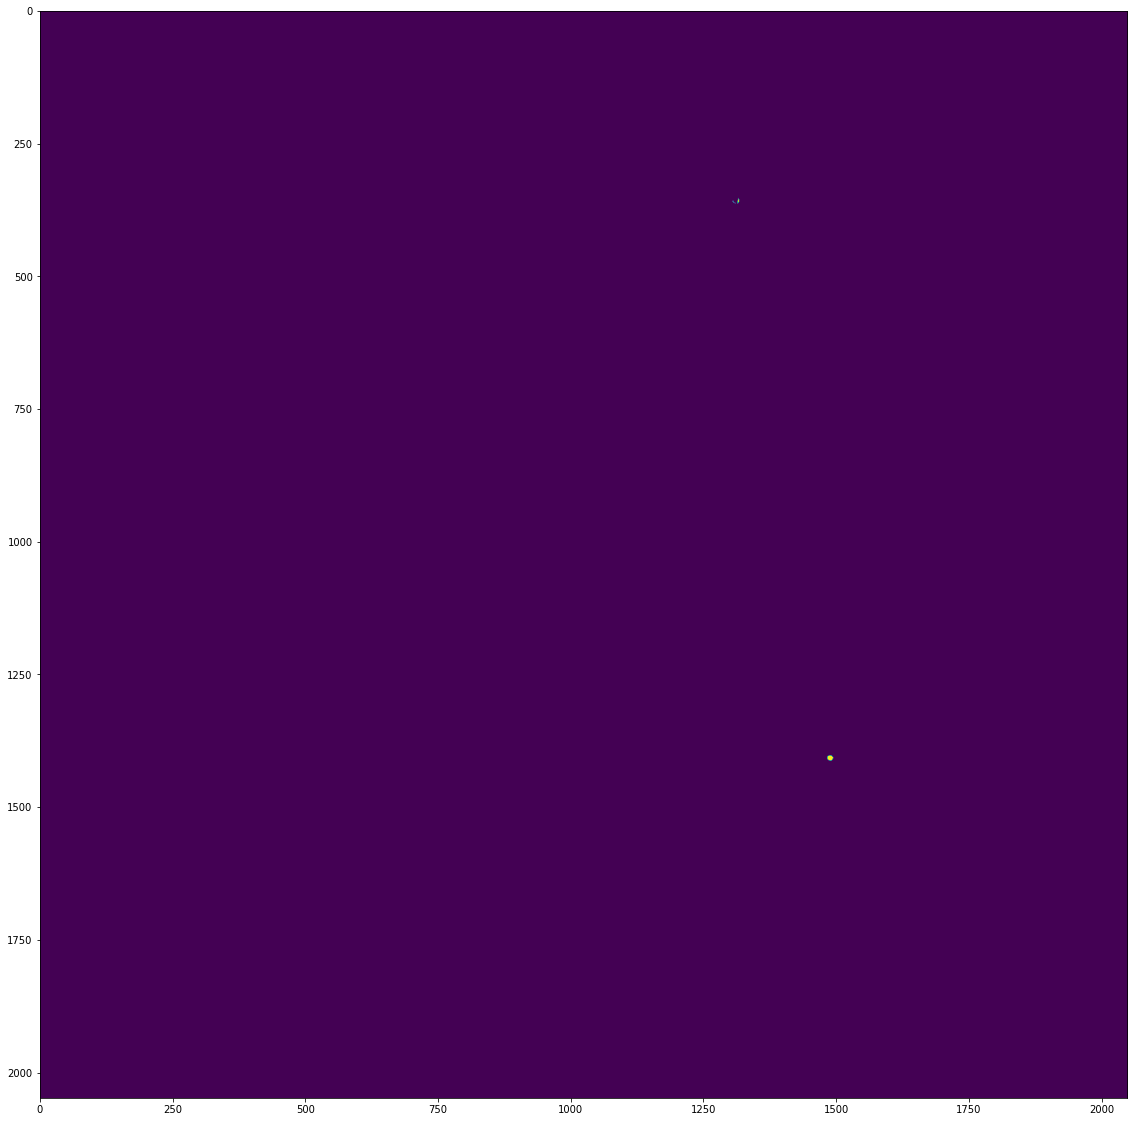

In [232]:
### check where are the bad colors located on an image
img = cv2.imread(output_dir + '20190405_2.0_kx_micro_1731_0000_ceta_mask.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
test_active = (img[:, :, 0] == 255).astype(int) + (img[:, :, 1] == 255).astype(int)*10 + (img[:, :, 2] == 255).astype(int)*100
bad_color = test_active == 110

plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(bad_color)

# Convert to COCO format<a id='format_coco'></a>

In [7]:
# Label ids of the dataset
category_ids = {
    "background": 0,
    "large_vesicle": 1,
    "small_vesicle": 2,
    "hole_vesicle": 3,
    "hole": 4,
    "vague_large_vesicle": 5
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0,# background
    "(255, 0, 0)": 1, # large_vesicle
    "(0, 255, 0)": 2, # small_vesicle
    "(255, 255, 0)": 3, # hole_vesicle
    "(0, 0, 255)": 4, # hole
    "(255, 255, 255)": 5, # vague_large_vesicle
}


keyword = ''
# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
# mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/'
# coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/'
# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'
# mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask_hole/'
# coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco_hole/'


# ['train', 'val']
for keyword in ['train', 'val']:

    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()

    # Create category section
    coco_format["categories"] = create_category_annotation(category_ids)

    # Create images and annotations sections
    input_dir = f'/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_{keyword}/'
    mask_dir = f'/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_{keyword}_mask/'
    coco_dir = f'/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_{keyword}_coco/'
    if not os.path.isdir(coco_dir):
        os.makedirs(coco_dir)
        
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir,
                                                                                                category_ids, category_colors)

    with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
        json.dump(coco_format, outfile)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))


Created 2861 annotations for images in folder: /Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train_mask/
Created 295 annotations for images in folder: /Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_val_mask/


# Visualize

### Customized visualization

In [14]:
# annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/image-to-coco-json-converter/output/val.json"
# image_dir = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/image-to-coco-json-converter/dataset/val"
# annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/train.json"
# image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train_coco/train.json"
image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_train/'

coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
# coco_dataset.display_categories()

html = coco_dataset.display_image(10, use_url=False)
IPython.display.HTML(html)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/vesicles_train_coco_2/train.json'

### Default visualization

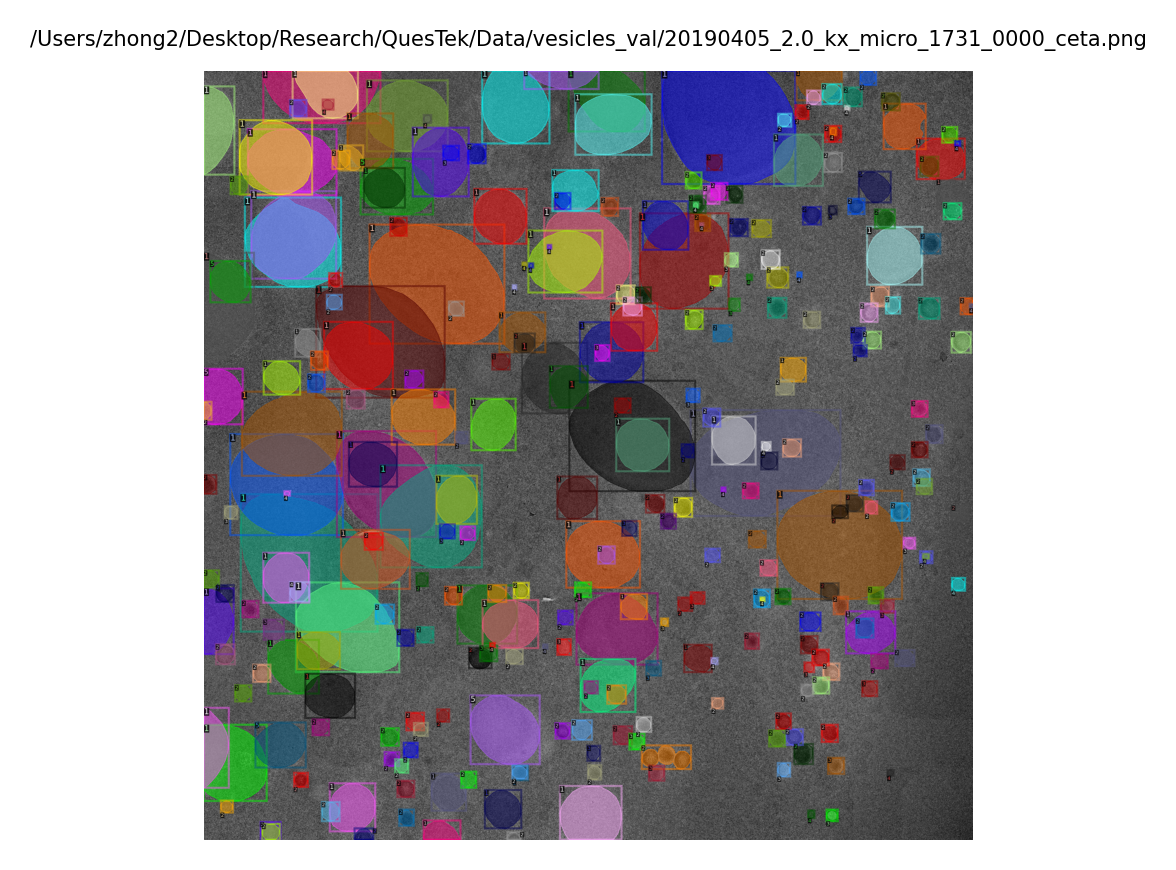

In [5]:
from detectron2.utils.visualizer import Visualizer

img_file = '/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_val/20190405_2.0_kx_micro_1731_0000_ceta.png'
f = open('/Users/zhong2/Desktop/Research/QuesTek/Data/vesicles_val_coco/val.json','r')
coco_format = json.load(f)
f.close()
visualizer = Visualizer(cv2.imread(img_file), scale=1)
vis = visualizer.draw_dataset_dict(coco_format)
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.imshow(vis.get_image())
ax.axis('off')
ax.set_title('{}'.format(img_file), fontsize=5)
fig.tight_layout()
plt.show()
# plt.close(fig)

# Register dataset <a id='register'></a>

In [494]:
DatasetCatalog.clear()
dataset_name = "vesicles_train"
annotation_file = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/train.json"
img_dir = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/"
# from .coco import load_coco_json, load_sem_seg

register_coco_instances(dataset_name, {}, 
                        annotation_file, 
                        img_dir)


In [495]:
print(f'Registered Datasets: {list(DatasetCatalog.data.keys())}')

Registered Datasets: ['tmp_dataset']


In [ ]:
coco_dataset = CocoDataset(train_annotation_file, train_img_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
# coco_dataset.display_categories()

html = coco_dataset.display_image(10, use_url=False)
IPython.display.HTML(html)



# Train model <a id='train'></a>

### Config

In [498]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from pathlib import Path

cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_name,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_name, dataset_name, )  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 400  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cpu'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400   # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 2000  # maximum number of iterations to run during training
  # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

### model weights will be downloaded if they are not present
weights_path = Path('models','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)

### make the output directory
cfg.OUTPUT_DIR = str(Path(f'maskrcnn_output'))
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)

Using locally stored weights: models/model_final_f10217.pkl


### Train

In [499]:
from detectron2.engine import DefaultTrainer, DefaultPredictor

trainer = DefaultTrainer(cfg)  # create trainer object from cfg
trainer.resume_or_load(resume=False)  # start training from iteration 0
trainer.train()  # train the model!



[09/07 15:28:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [09/07 15:28:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/07 15:28:08 d2.data.datasets.coco]: Loaded 2 images in COCO format from /Users/zhong2/Desktop/Research/QuesTek/vesicles_clean_coco/train.json
[09/07 15:28:08 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[09/07 15:28:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/07 15:28:08 d2.data.build]: Using training sampler TrainingSampler
[09/07 15:28:08 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[09/07 15:28:08 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [09/07 15:28:08 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[09/07 15:28:08 d2.checkpoint.c2_model_lo

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[09/07 15:28:08 d2.engine.train_loop]: Starting training from iteration 0
[09/07 15:32:06 d2.utils.events]:  eta: 6:35:35  iter: 19  total_loss: 3.08  loss_cls: 0.8244  loss_box_reg: 0.05869  loss_mask: 0.6635  loss_rpn_cls: 0.6795  loss_rpn_loc: 0.6196  time: 12.0667  data_time: 0.0101  lr: 0.00039962  
[09/07 15:32:49 d2.engine.hooks]: Overall training speed: 21 iterations in 0:04:19 (12.3605 s / it)
[09/07 15:32:49 d2.engine.hooks]: Total training time: 0:04:19 (0:00:00 on hooks)
[09/07 15:32:49 d2.utils.events]:  eta: 6:35:23  iter: 23  total_loss: 2.864  loss_cls: 0.7582  loss_box_reg: 0.1394  loss_mask: 0.63  loss_rpn_cls: 0.6584  loss_rpn_loc: 0.54  time: 12.1265  data_time: 0.0013  lr: 0.00045956  


KeyboardInterrupt: 

### Save results

# Evaluation <a id='eval'></a>

### Predict

### Visualize

# Debug
- background is also being annotated: visualize sub_masks['(0, 0, 0)']

True

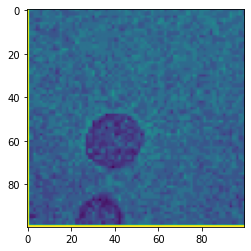

In [373]:
input_img_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/Photo Sep 02, 2 43 26 PM.png'
input_mask_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/Photo Sep 02, 2 43 26 PM_mask.png'
w_img_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/crop1.png'
w_mask_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/crop1_mask.png'
img = cv2.imread(input_img_name, 0)
mask = cv2.imread(input_mask_name)
img_crop = img[-100:, :100]
mask_crop = mask[-100:, :100, :]
plt.imshow(img_crop)


cv2.imwrite(w_img_name, img_crop)
cv2.imwrite(w_mask_name, mask_crop)


In [396]:
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'
mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask/'
coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco/'

if not os.path.isdir(coco_dir):
    os.makedirs(coco_dir)

    
#     for keyword in ['train', 'val']:
keyword = 'train'

# Get the standard COCO JSON format
coco_format = get_coco_json_format()

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir)

with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
    json.dump(coco_format, outfile)

print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))

Created 2 annotations for images in folder: /Users/zhong2/Desktop/Research/QuesTek/vesicles_easy_mask/


In [393]:
mask_format='png'
input_format='png'
multipolygon_ids = []
img_dir = input_dir

# This id will be automatically increased as we go
annotation_id = 0
image_id = 0
annotations = []
images = []


for mask_image in glob.glob(mask_dir + "*." + mask_format):
    # The mask image is *.png but the original image is *.jpg.
    # We make a reference to the original file in the COCO JSON file
    original_file_name = img_dir + mask_image.split('/')[-1].split('.')[0][:-5] + '.' + input_format

    # Open the image and (to be sure) we convert it to RGB
    mask_image_open = Image.open(mask_image).convert("RGB")
    w, h = mask_image_open.size

    # "images" info 
    image = create_image_annotation(original_file_name, w, h, image_id)
    images.append(image)

    sub_masks = create_sub_masks(mask_image_open, w, h)
    for color, sub_mask in sub_masks.items():
        category_id = category_colors[color]

        if category_ids['background'] == category_id:
            continue
        else:
            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)

                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]

                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)

                    annotations.append(annotation)
                    annotation_id += 1
        image_id += 1


In [435]:
from collections import Counter
# tmp = []
# for s in coco_format['annotations']:
#     tmp.append(s['area'])
# np.unique(tmp).shape

# tmp = []
# for s in coco_format['annotations']:
#     if s['area'] == 8203.5:
#         tmp.append(s)
# print(len(tmp))

tmp = defaultdict(list)
tmp2 = set()
tmp3 = Counter()
for s in coco_format['annotations']:
    bbox = s['bbox']
    tmp2.add(s['image_id'])
    tmp3[s['image_id']] += 1
    if s['image_id'] == 1:
        tmp[s['bbox']].append((s['category_id'], s['id']))
    
# tmp = 0
# for s in coco_format['annotations']:
#     if s['category_id'] == 0:
#         tmp += 1
# tmp

In [436]:
# print(np.sum(np.abs(np.array(tmp[0]['segmentation']) - np.array(tmp[1]['segmentation']))))
# print(tmp[0]['category_id'], tmp[1]['category_id'])

print(len(tmp.keys()))
tmp
print(len(coco_format['annotations']))
# tmp2
# coco_format
tmp3


87
174


Counter({0: 87, 1: 87})

True

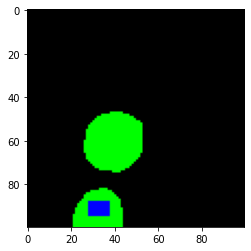

In [12]:
mask_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask/crop1_mask.png'
mask = cv2.imread(mask_name)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask[88:95, 28:38, 1] = 0
mask[88:95, 28:38, 2] = 255

plt.imshow(mask)
w_name = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask_hole/crop1_mask_hole.png'
cv2.imwrite(w_name, mask)



In [ ]:
# Label ids of the dataset
category_ids = {
    "background": 0,
    "large_vesicle": 1,
    "small_vesicle": 2,
    "hole_vesicle": 3,
    "hole": 4,
    "vague_large_vesicle": 5
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0,# background
    "(255, 0, 0)": 1, # large_vesicle
    "(0, 255, 0)": 2, # small_vesicle
    "(255, 255, 0)": 3, # hole_vesicle
    "(0, 0, 255)": 4, # hole
    "(255, 255, 255)": 5, # vague_large_vesicle
}


# input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_annotation/'
# mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_mask/'
# coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_clean_coco/'
input_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'
mask_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_mask_hole/'
coco_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco_hole/'

if not os.path.isdir(coco_dir):
    os.makedirs(coco_dir)

    
#     for keyword in ['train', 'val']:
keyword = 'train'

# Get the standard COCO JSON format
coco_format = get_coco_json_format()

# Create category section
coco_format["categories"] = create_category_annotation(category_ids)

# Create images and annotations sections
coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_dir, input_dir,
                                                                                           category_ids, category_colors)

with open(coco_dir + "/{}.json".format(keyword),"w") as outfile:
    json.dump(coco_format, outfile)

print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_dir))



### visualization
annotation_path = "/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy_coco_hole/train.json"
image_dir = '/Users/zhong2/Desktop/Research/QuesTek/Data_test/vesicles_easy/'

coco_dataset = CocoDataset(annotation_path, image_dir)
html = coco_dataset.display_image(0, use_url=False)
IPython.display.HTML(html)

In [106]:
### function create_sub_mask_annotation
sub_mask = sub_masks['(0, 255, 0)']

contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")
sub_mask_array = np.array(sub_mask)

polygons = []
segmentations = []
for contour in contours:
    # Flip from (row, col) representation to (x, y)
    # and subtract the padding pixel
    for i in range(len(contour)):
        row, col = contour[i]
        contour[i] = (col - 1, row - 1)

    # Check if the contour is a hole
    # !!!!!!!!!!!!!!! THIS LOGIC IS PROBLEMATIC !!!!!!!!!!!!!!!
    r_mask = np.zeros_like(np.array(sub_mask), dtype='bool')
    r_mask[np.round(contour[:, 1]).astype('int'), np.round(contour[:, 0]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    vals_in_contour = sub_mask_array[r_mask]
    if vals_in_contour.mean() < 0.5:
        print(vals.mean())
        continue
        
    # Make a polygon and simplify it
    poly = Polygon(contour)
    poly = poly.simplify(1.0, preserve_topology=False)

    if(poly.is_empty):
        # Go to next iteration, dont save empty values in list
        continue

    polygons.append(poly)

    segmentation = np.array(poly.exterior.coords).ravel().tolist()
    segmentations.append(segmentation)

len(segmentations)

0.22077922077922077


2